# Salt cave capacity extraction from two image
## background
- Becasue the author of paper 'Technical Potential of Salt Caverns for Hydrogen Storage in Europe' can't share their dataset with us, the only available data is two simple images in their paper


![Architecture 1](F1.png)
- salt caves hydrogen storage capacity in EU (only countries showed in this table have salt caves ) 

![Architecture 1](F2.png)
- six different capacity density (different color)


## Main task of this notebook
### Extract salt cave location 
### Extract salt cave capacity density of each location from original map
<br><br><br>
This Picture shows how to convert original map into a vector map with six different multipolygons
![Architecture 1](structure1.png)

------------------------------------


### estimate storage capacity of each polygon
- we assume that onshore salt caves located in the same country have same depth (average onshore depth in the country)
- we assume that offshore salt caves located in the same country have same depth (average onshore depth in the country)
------------------------------------
This Picture shows how to estimate capacity of each polygon in vector map
![Architecture 2](structure2.png)

In [23]:
import json
import pathlib

import cv2
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import re


from pathlib import Path
from osgeo import gdal, osr, ogr

import geopandas
import fiona
import rasterio
import rasterio.features
from shapely.geometry import shape, mapping
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import Point
import mapclassify
import geoplot.crs as gcrs

from tqdm import tqdm
import geoplot
import pycountry
from shapely.geometry import LineString

# Create GCPs
 - gcps is the projection of the original raster
 - It is manually created with help of QGIS and OSM map
 - It is saved as 'original/GCP_Points.json'
 
 This is GIS interface
 Just manually choose two point, QGIS automatically calculate coordinate of two points

![gcp](how_to_generate_gcps.png)

# View final data

In [3]:
# load capacity map
geodataframe = geopandas.read_file('result/final.shp')
geodataframe['geometry'] = geodataframe.geometry.buffer(0)

# load country shapes map
eu = geopandas.read_file('eu_shapes/country_shapes.geojson')
costa=geopandas.read_file('eu_shapes/offshore_shapes.geojson')

# create sub capacity map of germany
eu[eu['name'] == 'DE']
de=geopandas.GeoDataFrame(pd.concat([eu[eu['name'] == 'DE'],costa[costa['name']=='DE']],ignore_index=True))
geodataframe_de = geopandas.clip(geodataframe, de)
geodataframe_de

val_kwhm3                                           geometry
0        200  MULTIPOLYGON (((14.61900 51.94170, 14.64191 51...
1        250  MULTIPOLYGON (((14.75719 52.07916, 14.75645 52...
2        300  MULTIPOLYGON (((13.97755 52.30824, 13.97755 52...
3        350  MULTIPOLYGON (((14.36700 51.78134, 14.38991 51...
4        400  MULTIPOLYGON (((8.43364 54.04931, 8.43364 54.0...
5        450  MULTIPOLYGON (((14.61900 51.91880, 14.68812 51...

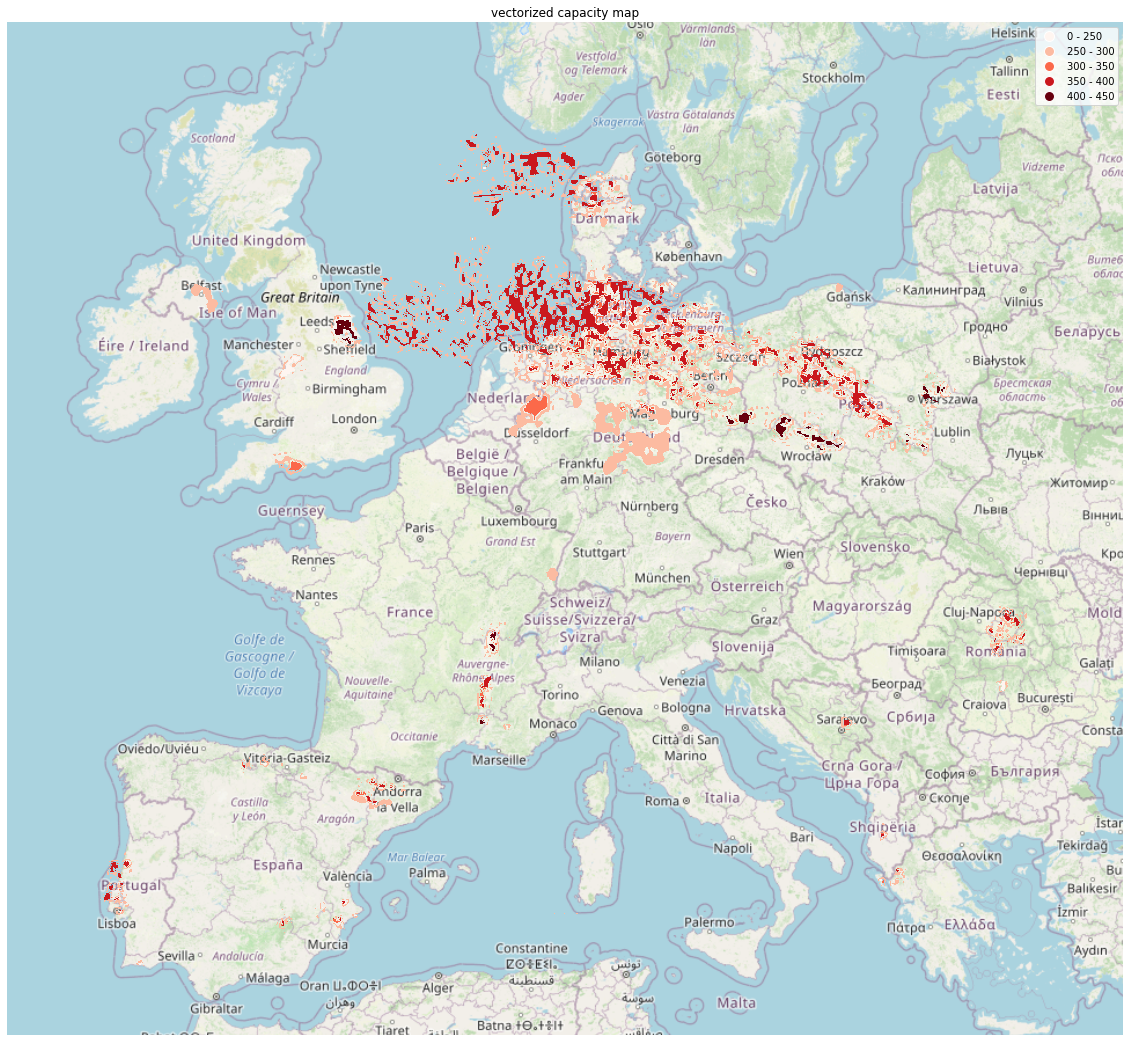

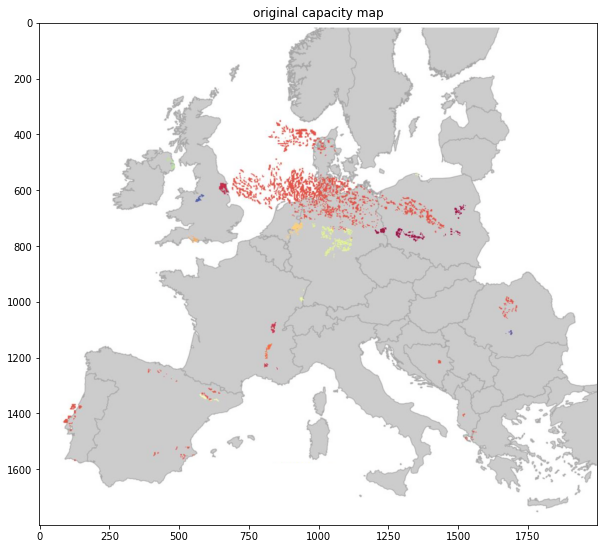

In [31]:
# plot capacity entire EU and compare with original raster
value = geodataframe['val_kwhm3']
scheme = mapclassify.Quantiles(value, k=5)

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_cities"))
ax = geoplot.webmap(eu, projection=gcrs.WebMercator(),
                    figsize=(20, 20), alpha=0.5)


geoplot.choropleth(
    geodataframe, hue=value, scheme=scheme, cmap='Reds',
    legend=True, edgecolor='white', linewidth=0.001, ax=ax
)
plt.title("vectorized capacity map")
plt.show()

# original map
img = cv2.imread('original/salt_cave.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ff = plt.figure(figsize=(10,10))
plt.imshow(img[:, 500:2500, :])
plt.title("original capacity map")
plt.show()

# sum to country level

In [11]:
eu_capacity=geopandas.read_file('sum2country.geojson')

# extract information in Figure 7 manually in QGIS


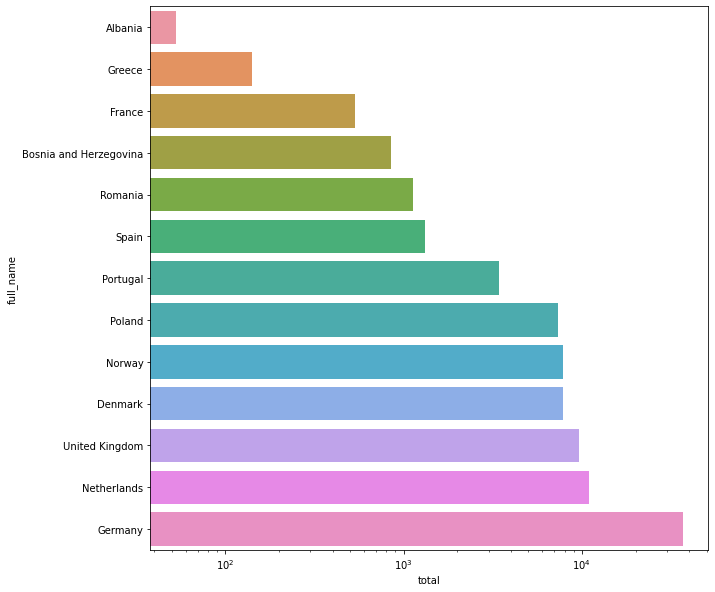

real storage capacity: 84.8 pwh total capacity of our extraction: 88.0187875313395 pwh 


In [30]:
graph_capacity=pd.read_csv('result/storage_potential_eu_kwh.csv')
import seaborn as sns
plt.figure(figsize=(10,10))
graph_capacity.total=graph_capacity.total/1e9
sns.barplot(y='full_name',x='total',data=graph_capacity,log=True)
plt.show()
print('real storage capacity: 84.8 pwh','total capacity of our extraction: {} pwh '.format(graph_capacity.total.sum()/1e3))

![Architecture 1](F1.png)

# Calculate depth per country (distinguish onshore and offshore) 

In [20]:
# load nodes data from Lisa
nodes = pd.read_csv('example_nodes_45.csv')

# convert lisa's data to GeoDataFrame
capacity_per_node = geopandas.GeoDataFrame(
    nodes, geometry=geopandas.points_from_xy(nodes['x'], nodes['y']))

# init capacity of each node with 0
capacity_per_node['capacity'] = 0
capacity_per_node.set_crs('EPSG:4326')
# load new capacity map capacity/area
result = geopandas.read_file('result/new_energy_density_map.geojson')

# calculate salt cave capacity for each polygon and convert from kwh to twh
result['capacity'] = result['val_kwhm2']\
    * result.to_crs(crs='EPSG:3395').area*1e-9
# unit twh

val_kwhm2                                           geometry   capacity
0      47.958683  POLYGON ((19.97965 40.96842, 20.00255 40.96842...   0.411418
1      71.938024  POLYGON ((20.36909 39.78483, 20.36909 39.80007...   0.153194
2      71.938024  POLYGON ((20.39200 39.81141, 20.39200 39.82446...   0.037924
3      71.938024  POLYGON ((20.18582 39.63971, 20.18663 39.63971...   0.000399
4      71.938024  POLYGON ((19.79638 40.85387, 19.81928 40.85387...   0.616051
...          ...                                                ...        ...
3878  140.672107  POLYGON ((24.37812 46.74142, 24.46976 46.74142...  13.300370
3879  140.672107  POLYGON ((24.28649 46.14579, 24.30940 46.14579...  32.856128
3880  140.672107  POLYGON ((24.14904 46.28324, 24.17195 46.28324...   2.637957
3881  140.672107  POLYGON ((24.17195 46.28324, 24.17195 46.32906...   6.600723
3882  140.672107  POLYGON ((23.96577 46.55815, 23.98868 46.55815...  17.224601

[3883 rows x 3 columns]

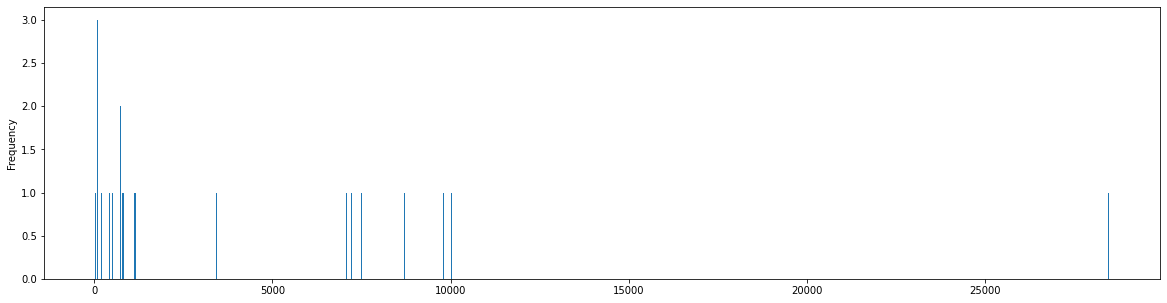

In [23]:
capacity_per_node[capacity_per_node.capacity>0].capacity.plot.hist(bins=1000, figsize=(20,5))

plt.show()
#Histogram of hydrogen storage capacity in EU
#unit Twh

In [11]:
from pypsa import Network

In [62]:
network = Network()
network.import_from_netcdf('../../../pypsa-eur/networks/with_hydrogen_stoage_elec_s_256.nc')

INFO:pypsa.io:Imported network with_hydrogen_stoage_elec_s_256.nc has buses, carriers, generators, lines, links, loads, storage_units


In [63]:
m=network.buses

In [64]:
m['point']=list(zip(m['x'],m['y']))

In [65]:
m['geometry']=m.point.apply(Point)

In [66]:
view=geopandas.GeoDataFrame(m[['geometry','hydrogen_storage_potential_twh']],crs='EPSG:4326')
view.columns=['geometry','capacity']

In [67]:
view[view.capacity.isnull()]

Empty GeoDataFrame
Columns: [geometry, capacity]
Index: []

/opt/anaconda3/envs/geoproject/lib/python3.6/site-packages/mapclassify/classifiers.py:235: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/opt/anaconda3/envs/geoproject/lib/python3.6/site-packages/mapclassify/classifiers.py:237: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<GeoAxesSubplot:>

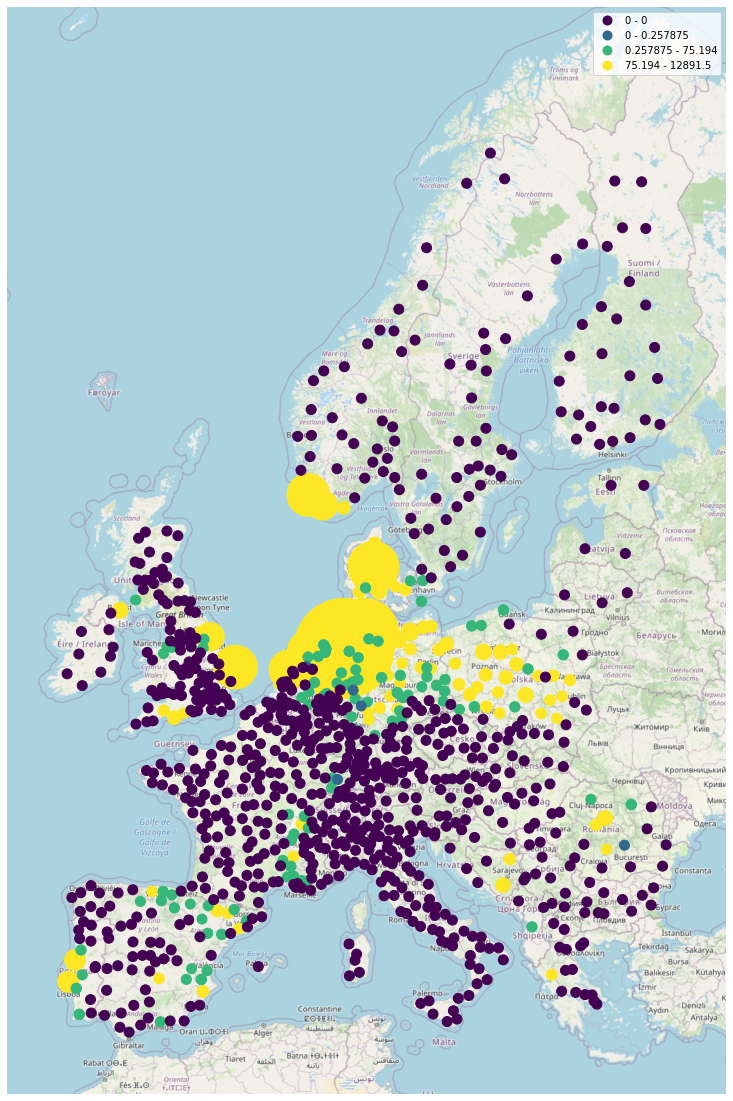

In [61]:
eu=geopandas.read_file('eu_shapes/country_shapes.geojson')
ax = geoplot.webmap(eu,projection=gcrs.WebMercator(),figsize=(30,20),alpha=0.5)

scheme1 = mapclassify.Quantiles(view[view.capacity.notnull()].capacity, k=10)

#plot nodes
geoplot.pointplot(
    view[view.capacity.notnull()] , projection=gcrs.AlbersEqualArea(),
    scale='capacity', limits=(10, 100),
    hue='capacity', cmap='viridis', scheme=scheme1,
    legend=True, legend_var='hue',
    ax=ax
)

<GeoAxesSubplot:>

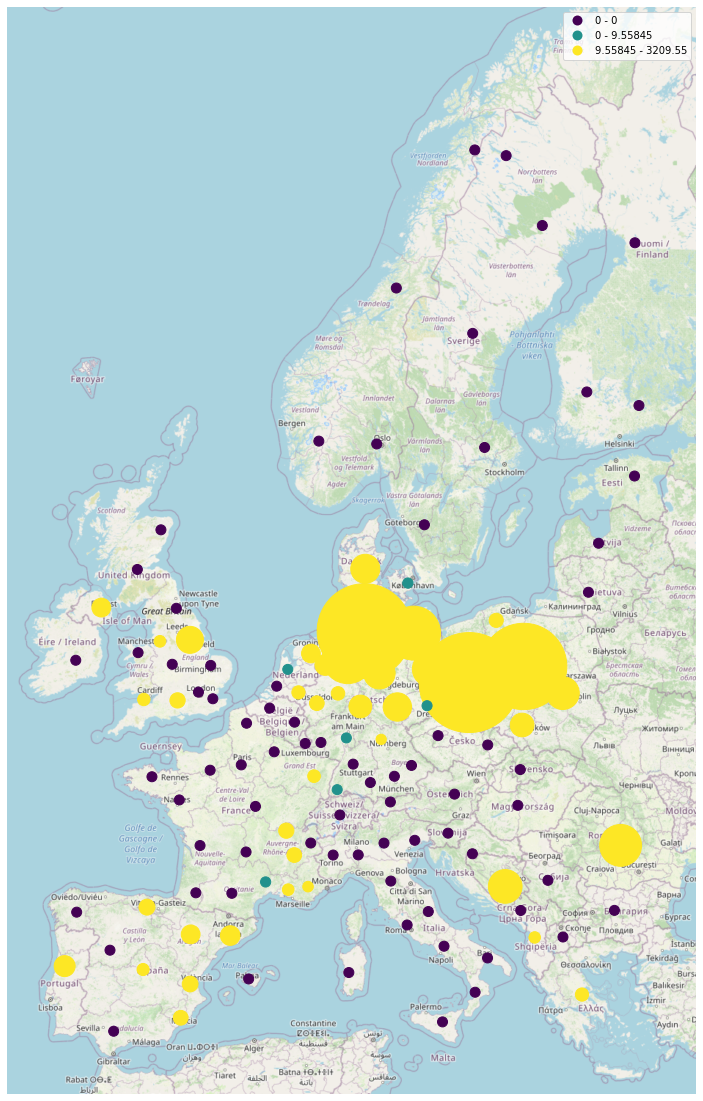

In [38]:
eu=geopandas.read_file('eu_shapes/country_shapes.geojson')
ax = geoplot.webmap(eu,projection=gcrs.WebMercator(),figsize=(30,20),alpha=0.5)

scheme1 = mapclassify.Quantiles(capacity_per_node.capacity, k=3)

#plot nodes
geoplot.pointplot(
    capacity_per_node , projection=gcrs.AlbersEqualArea(),
    scale='capacity', limits=(10, 100),
    hue='capacity', cmap='viridis', scheme=scheme1,
    legend=True, legend_var='hue',
    ax=ax
)

<GeoAxesSubplot:>

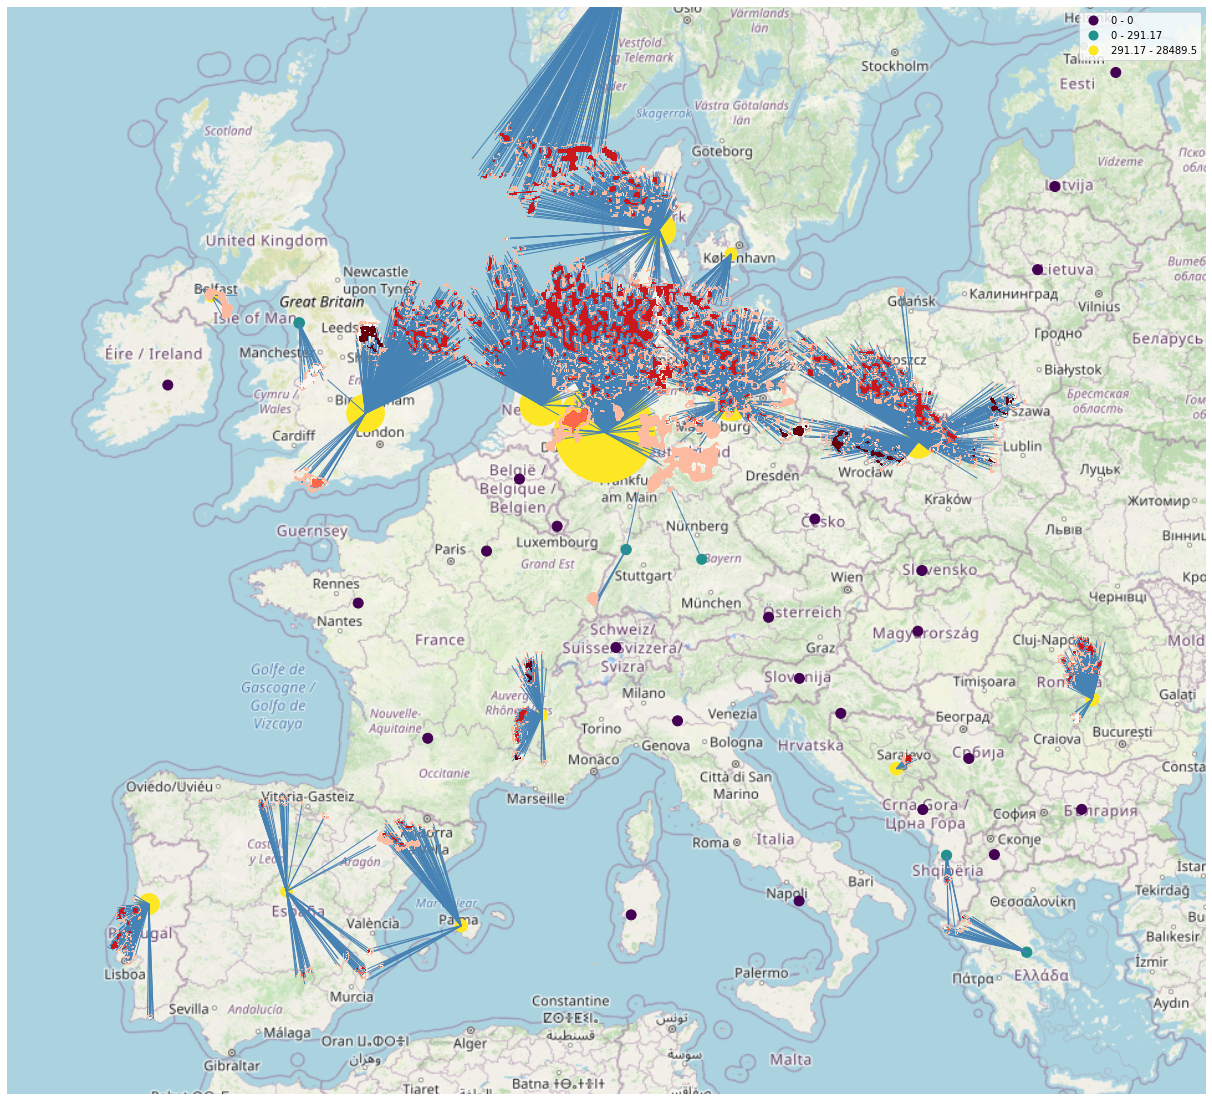

In [32]:
eu=geopandas.read_file('eu_shapes/country_shapes.geojson')
ax = geoplot.webmap(eu,projection=gcrs.WebMercator(),figsize=(30,20),alpha=0.5)

scheme1 = mapclassify.Quantiles(capacity_per_node.capacity, k=3)

#plot mapping relationship
geoplot.sankey(geopandas.GeoDataFrame(geometry=lines),ax=ax)

#plot nodes
geoplot.pointplot(
    capacity_per_node , projection=gcrs.AlbersEqualArea(),
    scale='capacity', limits=(10, 100),
    hue='capacity', cmap='viridis', scheme=scheme1,
    legend=True, legend_var='hue',
    ax=ax
)

#plot energy density map
value = geodataframe['val_kwhm3']
scheme = mapclassify.Quantiles(value, k=5)
geoplot.choropleth(
   geodataframe, hue=value,scheme=scheme,cmap='Reds',
    legend=False,edgecolor='white',linewidth=0.001,ax=ax
)

